# Ray et al 2013 Evaluation
**Authorship:**
Adam Klie, *08/31/2022*
***
**Description:**
Notebook to evaluate trained models on the Ray et al dataset.
***

In [20]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

import os
import glob
import logging
import torch
import numpy as np
import pandas as pd
import eugene as eu
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [1]:
eu.settings.dataset_dir = "/cellar/users/aklie/data/eugene/ray13"
eu.settings.output_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/ray13"
eu.settings.logging_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/logs/ray13"
eu.settings.config_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/configs/ray13"
figure_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/figures/ray13"
eu.settings.verbosity = logging.ERROR

NameError: name 'eu' is not defined

# Load in the test `SeqData`

In [22]:
# Load the test data
sdata_test = eu.dl.read_h5sd(os.path.join(eu.settings.dataset_dir, "norm_setB_processed_ST.h5sd"))
target_mask = sdata_test.seqs_annot.columns.str.contains("RNCMPT")
target_cols = sdata_test.seqs_annot.columns[target_mask]
sdata_test

SeqData object with = 121031 seqs
seqs = (121031,)
names = (121031,)
rev_seqs = None
ohe_seqs = (121031, 41, 4)
ohe_rev_seqs = None
seqs_annot: 'Probe_Set', 'RNCMPT00001', 'RNCMPT00002', 'RNCMPT00003', 'RNCMPT00004', 'RNCMPT00005', 'RNCMPT00006', 'RNCMPT00007', 'RNCMPT00008', 'RNCMPT00009', 'RNCMPT00010', 'RNCMPT00011', 'RNCMPT00012', 'RNCMPT00013', 'RNCMPT00014', 'RNCMPT00015', 'RNCMPT00016', 'RNCMPT00017', 'RNCMPT00018', 'RNCMPT00019', 'RNCMPT00020', 'RNCMPT00021', 'RNCMPT00022', 'RNCMPT00023', 'RNCMPT00024', 'RNCMPT00025', 'RNCMPT00026', 'RNCMPT00027', 'RNCMPT00028', 'RNCMPT00029', 'RNCMPT00031', 'RNCMPT00032', 'RNCMPT00033', 'RNCMPT00034', 'RNCMPT00035', 'RNCMPT00036', 'RNCMPT00037', 'RNCMPT00038', 'RNCMPT00039', 'RNCMPT00040', 'RNCMPT00041', 'RNCMPT00042', 'RNCMPT00043', 'RNCMPT00044', 'RNCMPT00045', 'RNCMPT00046', 'RNCMPT00047', 'RNCMPT00049', 'RNCMPT00050', 'RNCMPT00051', 'RNCMPT00052', 'RNCMPT00053', 'RNCMPT00054', 'RNCMPT00055', 'RNCMPT00056', 'RNCMPT00057', 'RNCMPT00058', 'RN

In [4]:
# Load in the Set B presence/absence predictions
b_presence_absence = np.load(os.path.join(eu.settings.dataset_dir, "SetB_binary.npy"))
setB_observed = sdata_test.seqs_annot[target_cols]

# Get test set evaluations for each model

## SetA k-mer scores 

In [7]:
# Load in the Set A presence/absence predictions
a_presence_absence = np.load(os.path.join(eu.settings.dataset_dir, "SetA_binary_ST.npy"))
setA_observed = eu.dl.read_h5sd(os.path.join(eu.settings.dataset_dir, eu.settings.dataset_dir, "norm_setA_processed_ST.h5sd")).seqs_annot[target_cols]

In [8]:
# An example calculation of z-scores, aucs and e-scores for Set A and Set B
a_metr = eu.predict.rna_complete_metrics_apply(a_presence_absence, setA_observed["RNCMPT00001"].values, verbose=True, num_kmers=100)
b_metr = eu.predict.rna_complete_metrics_apply(b_presence_absence, setB_observed["RNCMPT00001"].values, verbose=True, num_kmers=100)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
# Performing the above calculation for all targets (TODO: parallelize and simplify)
from scipy.stats import pearsonr, spearmanr
pearson_setA_long = pd.DataFrame()
spearman_setA_long = pd.DataFrame()
for i, task in tqdm(enumerate(target_cols[:3]), desc="Calcualting metrics on each task", total=len(target_cols)):
    a_zscores, a_aucs, a_escores  = eu.predict.rna_complete_metrics_apply(a_presence_absence, setA_observed[task].values, verbose=True, use_calc_auc=True, num_kmers=100)
    b_zscores, b_aucs, b_escores = eu.predict.rna_complete_metrics_apply(b_presence_absence, setB_observed[task].values, verbose=True, use_calc_auc=True, num_kmers=100) 
    
    zscore_nan_mask = np.isnan(a_zscores) | np.isnan(b_zscores)
    a_zscores = a_zscores[~zscore_nan_mask]
    b_zscores = b_zscores[~zscore_nan_mask]
    if len(a_zscores) > 0 and len(b_zscores) > 0:
        pearson_setA_long = pearson_setA_long.append(pd.Series({"RBP": task, "Metric": "Z-score", "Pearson": pearsonr(a_zscores, b_zscores)[0]}), ignore_index=True)
        spearman_setA_long = spearman_setA_long.append(pd.Series({"RBP": task, "Metric": "Z-score", "Spearman": spearmanr(a_zscores, b_zscores)[0]}), ignore_index=True)

    auc_nan_mask = np.isnan(a_aucs) | np.isnan(b_aucs)
    a_aucs = a_aucs[~auc_nan_mask]
    b_aucs = b_aucs[~auc_nan_mask]
    if len(a_aucs) > 0 and len(b_aucs) > 0:
        pearson_setA_long = pearson_setA_long.append(pd.Series({"RBP": task, "Metric": "AUC", "Pearson": pearsonr(a_aucs, b_aucs)[0]}), ignore_index=True)
        spearman_setA_long = spearman_setA_long.append(pd.Series({"RBP": task, "Metric": "AUC", "Spearman": spearmanr(a_aucs, b_aucs)[0]}), ignore_index=True)
    
    escore_nan_mask = np.isnan(a_escores) | np.isnan(b_escores)
    a_escores = a_escores[~escore_nan_mask]
    b_escores = b_escores[~escore_nan_mask]
    if len(a_escores) > 0 and len(b_escores) > 0:
        pearson_setA_long = pearson_setA_long.append(pd.Series({"RBP": task, "Metric": "E-score", "Pearson": pearsonr(a_escores, b_escores)[0]}), ignore_index=True)
        spearman_setA_long = spearman_setA_long.append(pd.Series({"RBP": task, "Metric": "E-score", "Spearman": spearmanr(a_escores, b_escores)[0]}), ignore_index=True)

pearson_setA_long["Model"] = "SetA"
spearman_setA_long["Model"] = "SetA"

Calcualting metrics on each task:   0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
# Memory cleanup
del a_presence_absence

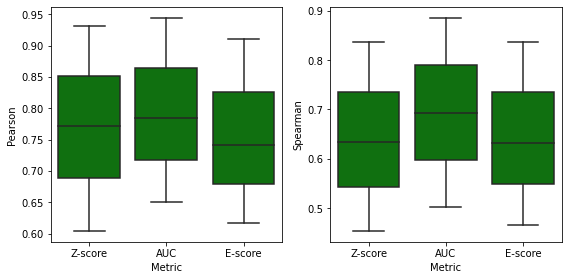

In [25]:
# Plot just the SetA results 
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.boxplot(data=pearson_setA_long, x="Metric", y="Pearson", color="green", ax=ax[0])
sns.boxplot(data=spearman_setA_long, x="Metric", y="Spearman", color="green", ax=ax[1])
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, "correlation_boxplots_setA.pdf"))

## Single-task model evaluation 

In [56]:
# Get predictions on the test data from all single task models
for i, target_col in enumerate(target_cols[:20]):
    print(f"Testing DeepBind SingleTask model on {target_col}")
    try:
        model_file = glob.glob(os.path.join(eu.settings.logging_dir, "DeepBind_ST", target_col, "checkpoints", "*"))[0]
        model = eu.models.DeepBind.load_from_checkpoint(model_file)
    except:
        print(f"No model trained for {target_col}")
        continue
    eu.settings.dl_num_workers = 0
    eu.predict.predictions(
        model,
        sdata=sdata_test, 
        target=target_col,
        name="DeepBind_ST",
        version=target_col,
        file_label="test",
        suffix="_ST"
    )
    del model

Testing DeepBind SingleTask model on RNCMPT00001
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

Testing DeepBind SingleTask model on RNCMPT00002
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

Testing DeepBind SingleTask model on RNCMPT00003
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

Testing DeepBind SingleTask model on RNCMPT00004
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

Testing DeepBind SingleTask model on RNCMPT00005
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

Testing DeepBind SingleTask model on RNCMPT00006
No model trained for RNCMPT00006
Testing DeepBind SingleTask model on RNCMPT00007
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + RNCMPT00007_predictions_ST
Testing DeepBind SingleTask model on RNCMPT00008
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + RNCMPT00008_predictions_ST
Testing DeepBind SingleTask model on RNCMPT00009
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + RNCMPT00009_predictions_ST
Testing DeepBind SingleTask model on RNCMPT00010
No model trained for RNCMPT00010
Testing DeepBind SingleTask model on RNCMPT00011
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + RNCMPT00011_predictions_ST
Testing DeepBind SingleTask model on RNCMPT00012
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + RNCMPT00012_predictions_ST
Testing DeepBind SingleTask model on RNCMPT00013
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + RNCMPT00013_predictions_ST
Testing DeepBind SingleTask model on RNCMPT00014
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + RNCMPT00014_predictions_ST
Testing DeepBind SingleTask model on RNCMPT00015
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + RNCMPT00015_predictions_ST
Testing DeepBind SingleTask model on RNCMPT00016
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + RNCMPT00016_predictions_ST
Testing DeepBind SingleTask model on RNCMPT00017
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + RNCMPT00017_predictions_ST
Testing DeepBind SingleTask model on RNCMPT00018
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + RNCMPT00018_predictions_ST
Testing DeepBind SingleTask model on RNCMPT00019
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + RNCMPT00019_predictions_ST
Testing DeepBind SingleTask model on RNCMPT00020
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + RNCMPT00020_predictions_ST


In [29]:
# Get evaluation metrics for all single task models and format for plotting
pearson_ST_df, spearman_ST_df = eu.predict.summarize_rbps_apply(sdata_test, b_presence_absence, target_cols[:3], use_calc_auc=True, verbose=True, n_kmers=100, preds_suffix="_predictions_ST")
pearson_ST_long = pearson_ST_df.reset_index().melt(id_vars="index", value_name="Pearson", var_name="Metric").rename({"index":"RBP"}, axis=1)
spearman_ST_long = spearman_ST_df.reset_index().melt(id_vars="index", value_name="Spearman", var_name="Metric").rename({"index":"RBP"}, axis=1)
pearson_ST_long["Model"] = "SingleTask"
spearman_ST_long["Model"] = "SingleTask"

Evaluating probes:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

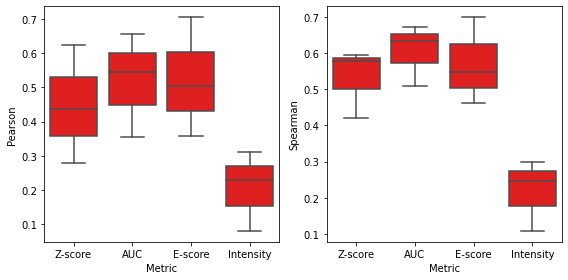

In [30]:
# Plot just the single task model eval
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.boxplot(data=pearson_ST_long, x="Metric", y="Pearson", color="red", ax=ax[0])
sns.boxplot(data=spearman_ST_long, x="Metric", y="Spearman", color="red", ax=ax[1])
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, "correlation_boxplots_ST.pdf"))

## Multitask model evaluation

In [35]:
# Also need the multi-task columns (single task we could train on all the columns)
sdata_training = eu.dl.read_h5sd(os.path.join(eu.settings.dataset_dir, eu.settings.dataset_dir, "norm_setA_sub_MT.h5sd"))
target_mask_MT = sdata_training.seqs_annot.columns.str.contains("RNCMPT")
target_cols_MT = sdata_training.seqs_annot.columns[target_mask_MT]
del sdata_training
len(target_cols_MT)

233

In [36]:
# Get predictions on the test data from all multi task models
print("Testing DeepBind MultiTask model on")
version = 0
model_file = glob.glob(os.path.join(eu.settings.logging_dir, "DeepBind_MT", f"v{version}", "checkpoints", "*"))[0]
model = eu.models.DeepBind.load_from_checkpoint(model_file)
eu.settings.dl_num_workers = 0
eu.predict.predictions(
    model,
    sdata=sdata_test, 
    target=target_cols_MT,
    name="DeepBind_MT",
    version=f"v{version}",
    file_label="test",
    suffix="_MT"
)
del model

Testing DeepBind MultiTask model on
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Predicting: 0it [00:00, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/pandas/core/frame.py:3636: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


SeqData object modified:
    seqs_annot:
        + RNCMPT00187_predictions_MT, RNCMPT00138_predictions_MT, RNCMPT00073_predictions_MT, RNCMPT00117_predictions_MT, RNCMPT00197_predictions_MT, RNCMPT00076_predictions_MT, RNCMPT00139_predictions_MT, RNCMPT00265_predictions_MT, RNCMPT00285_predictions_MT, RNCMPT00284_predictions_MT, RNCMPT00012_predictions_MT, RNCMPT00121_predictions_MT, RNCMPT00291_predictions_MT, RNCMPT00056_predictions_MT, RNCMPT00143_predictions_MT, RNCMPT00091_predictions_MT, RNCMPT00111_predictions_MT, RNCMPT00241_predictions_MT, RNCMPT00239_predictions_MT, RNCMPT00068_predictions_MT, RNCMPT00086_predictions_MT, RNCMPT00236_predictions_MT, RNCMPT00023_predictions_MT, RNCMPT00090_predictions_MT, RNCMPT00057_predictions_MT, RNCMPT00219_predictions_MT, RNCMPT00010_predictions_MT, RNCMPT00175_predictions_MT, RNCMPT00203_predictions_MT, RNCMPT00226_predictions_MT, RNCMPT00258_predictions_MT, RNCMPT00038_predictions_MT, RNCMPT00289_predictions_MT, RNCMPT00184_predictions_M

In [37]:
# Get evaluation metrics for all single task models and format for plotting
pearson_MT_df, spearman_MT_df = eu.predict.summarize_rbps_apply(sdata_test, b_presence_absence, target_cols_MT[:3], use_calc_auc=True, verbose=True, n_kmers=100, preds_suffix="_predictions_MT")
pearson_MT_long = pearson_MT_df.reset_index().melt(id_vars="index", value_name="Pearson", var_name="Metric").rename({"index":"RBP"}, axis=1)
spearman_MT_long = spearman_MT_df.reset_index().melt(id_vars="index", value_name="Spearman", var_name="Metric").rename({"index":"RBP"}, axis=1)
pearson_MT_long["Model"] = "MultiTask"
spearman_MT_long["Model"] = "MultiTask"

Evaluating probes:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

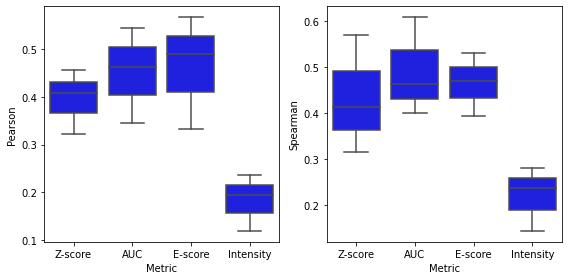

In [38]:
# Plot just the multi task model eval
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.boxplot(data=pearson_MT_long, x="Metric", y="Pearson", color="blue", ax=ax[0])
sns.boxplot(data=spearman_MT_long, x="Metric", y="Spearman", color="blue", ax=ax[1])
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, "correlation_boxplots_MT.pdf"))

# Model comparisons

In [39]:
# Save the sdata with the predictions for the Set A, single task, and multitask models
sdata_test.write_h5sd(os.path.join(eu.settings.output_dir, "norm_test_predictions.h5sd"))

In [40]:
# Concatenate the dataframes for plotting across models
pearson_long = pd.concat([pearson_setA_long, pearson_MT_long, pearson_ST_long])
spearman_long = pd.concat([spearman_setA_long, spearman_MT_long, spearman_ST_long])
pearson_models = pearson_long.pivot(index=["RBP", "Metric"], columns="Model", values="Pearson").reset_index()
spearman_models = spearman_long.pivot(index=["RBP", "Metric"], columns="Model", values="Spearman").reset_index()

In [50]:
# Helper function to plot the a line to apply to FacetGrid
def const_line(*args, **kwargs):
    x = np.arange(0, 1.01, 0.01)
    plt.plot(x, x, c='k', ls='--')

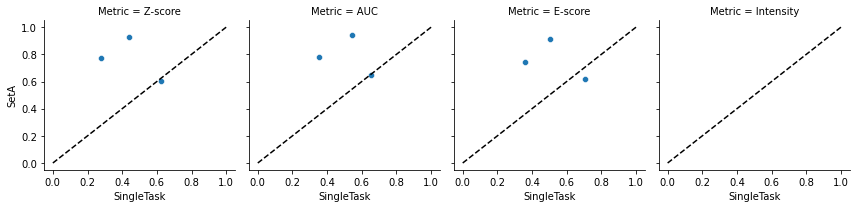

In [51]:
# Plot the evaluation metrics comparisons for single task vs SetA Pearson correlation
g = sns.FacetGrid(pearson_models, col="Metric", col_order=["Z-score", "AUC", "E-score", "Intensity"])
g.map(sns.scatterplot, "SingleTask", "SetA")
g.map(const_line)
plt.savefig(os.path.join(figure_dir, "model_pearson_scatterplot_comparisons_ST_setA_.pdf"))

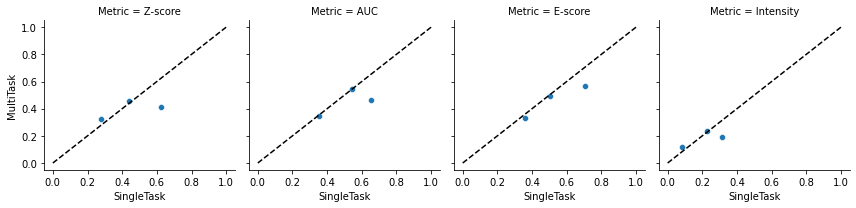

In [52]:
# Plot the evaluation metrics comparisons for single task vs multitask using Pearson correlation
g = sns.FacetGrid(pearson_models, col="Metric", col_order=["Z-score", "AUC", "E-score", "Intensity"])
g.map(sns.scatterplot, "SingleTask", "MultiTask")
g.map(const_line)
plt.savefig(os.path.join(figure_dir, "model_pearson_scatterplot_comparisons_ST_MT.pdf"))

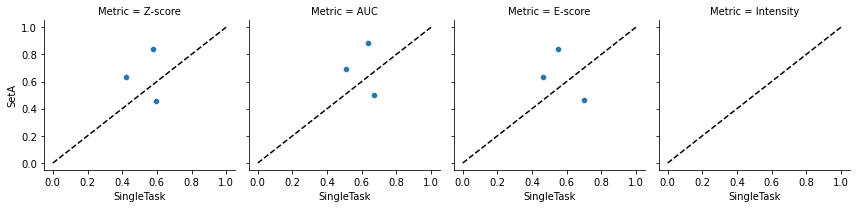

In [53]:
# Plot the evaluation metrics comparisons for single task vs SetA using Spearman correlation
g = sns.FacetGrid(spearman_models, col="Metric", col_order=["Z-score", "AUC", "E-score", "Intensity"])
g.map(sns.scatterplot, "SingleTask", "SetA")
g.map(const_line)
plt.savefig(os.path.join(figure_dir, "model_spearman_scatterplot_comparisons_ST_setA.pdf"))

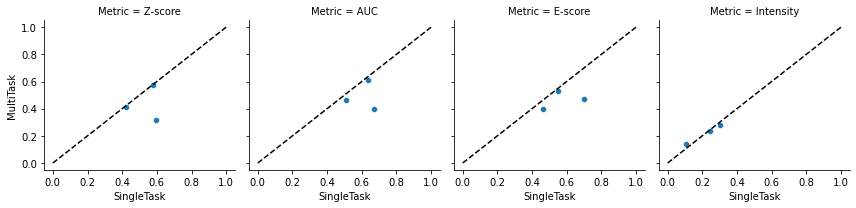

In [54]:
# Plot the evaluation metrics comparisons for single task vs multitask using Spearman correlation
g = sns.FacetGrid(spearman_models, col="Metric", col_order=["Z-score", "AUC", "E-score", "Intensity"])
g.map(sns.scatterplot, "SingleTask", "MultiTask")
g.map(const_line)
plt.savefig(os.path.join(figure_dir, "model_spearman_scatterplot_comparisons_ST_MT.pdf"))

---

# Scratch

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

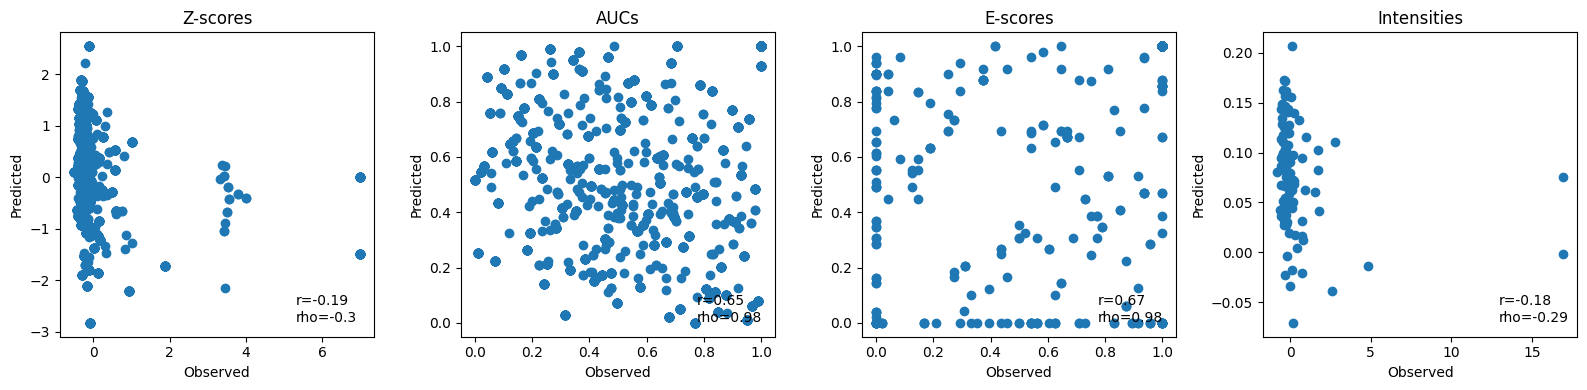

In [ ]:
eu.predict.column_rnac_metrics_apply(sdata_test, b_presence_absence, probe_id="RNCMPT00001", preds_suffix="_predictions_ST", use_calc_auc=True, verbose=True, n_kmers=100)

  0%|          | 0/100 [00:00<?, ?it/s]

/home/vscode/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/vscode/.local/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/100 [00:00<?, ?it/s]

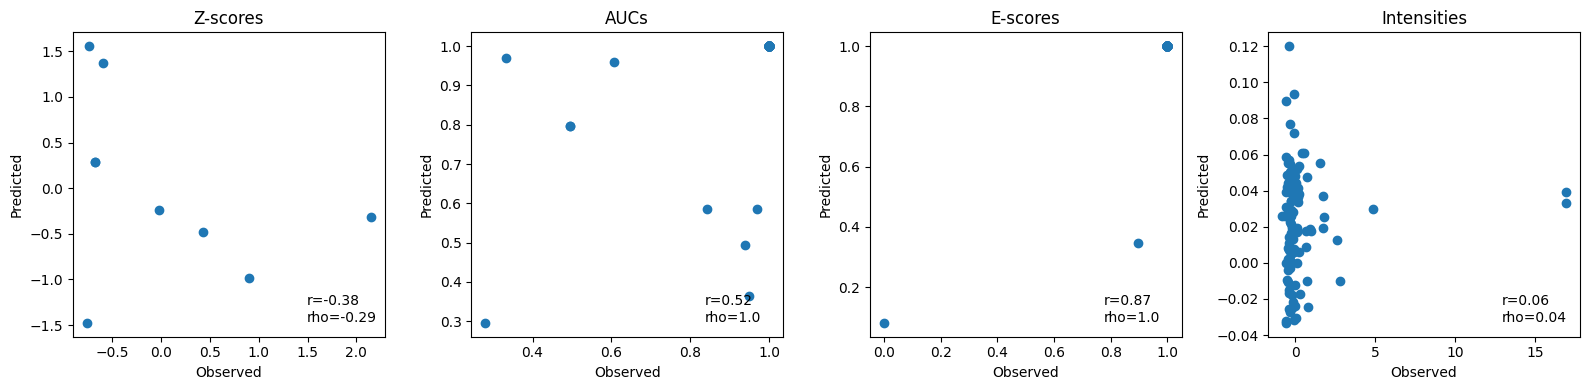

In [ ]:
eu.predict.column_rnac_metrics_apply(sdata_test, b_presence_absence, probe_id="RNCMPT00001", preds_suffix="_predictions_MT", use_calc_auc=True, verbose=True, n_kmers=100)